# Fit the complete data (With sWeights and without sWeights)
- Fit on $m(B^0_s)$ with $m(3\pi)$ around $m(D_s)$ and sWeights
    - Signal $B^0 \to D^{*-} \pi^+ \pi^+ \pi^-$ (gaussian)
    - Background of partially reconstructed decays (gaussian)
    - Combinatorial background (exponential)
- Fit on $m(B^0_s)$ with:
    - Signal $B^0 \to D^{*-} \pi^+ \pi^+ \pi^-$ (sum of two Crystall ball PDF)
    - Background $B^0 \to D^{*-} D_s^+$ from the other fit of the simultaneous fit
    - Background with a misidentified pion: $B^0 \to D^{*-} K^+ \pi^+ \pi^-$ (sum of two crystall ball PDF)
    - Background of partially reconstructed decays $B^0 \to D^{*-} \pi^+ \pi^+ \pi^- h$ (gaussian)
    - Combinatorial background (exponential)

Those two fits are not simultaneous

## Import

In [1]:
import zfit
import json
import numpy as np

from bd2dst3pi.locations import loc
from bd2dst3pi.definitions import years, magnets

import sys
sys.path.append(loc.SCRIPTS)
import functions as fct
from fit import launch_fit, save_params, plot_hist_fit, plot_hist_fit_particle

Welcome to JupyROOT 6.22/02


## Load

In [2]:
# Mean of the distribution of the partially reconstructed data
with open(f'{loc.JSON}/data_strip_p/all_data_strip_params.json', 'r') as f:
    mu2_p = json.load(f)['mu2']


In [3]:
df = fct.load_data(years, magnets, type_data='data_strip', vars=['B0_M','tau_M'],
                            cut_DeltaM=True)

/afs/cern.ch/user/c/correian/bd2dst3pi/output/root/data_strip/all_data_strip.root


In [4]:
name_data = 'all_data_strip_cutDeltaM_V8_fixedTail'
name_data_B0Ds = 'all_data_strip_cutDeltaM_V8_B0Ds'

## Fit on weighted `B0_M` with `|tau_M-1969|<50`

### Data

In [5]:
size_tau_M = 50.
mean_tau_M = 1969.
low_tau_M = mean_tau_M - size_tau_M
high_tau_M = mean_tau_M + size_tau_M

df_Ds = df.query(f"abs(tau_M-{mean_tau_M})<={size_tau_M}")

In [6]:
name_data_B0Ds = 'all_data_strip_cutDeltaM_Ds_weighted_V8'
low_B0Ds = 5150.
high_B0Ds = 5360.

weights =  fct.retrieve_pickle('all_data_strip_cutDeltaM_Ds_V8')

### Distributions

/afs/cern.ch/user/c/correian/bd2dst3pi/scripts/functions.py:579: RuntimeWarning: invalid value encountered in sqrt
  err = np.sqrt(counts)


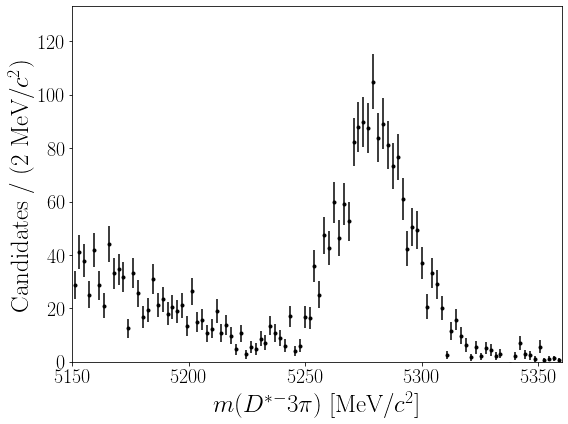

/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/B0_M_all_data_strip_cutDeltaM_Ds_weighted_V8.pdf


In [8]:
fct.plot_hist_particle({name_data_B0Ds:df_Ds},'B0_M',
              low = low_B0Ds, high = high_B0Ds,
              n_bins = 100, mode_hist = False, colors='black', weights=weights.sig)

### Intial values

In [7]:
n_events_B0Ds = len(df_Ds.query(f'B0_M > {low_B0Ds} and B0_M < {high_B0Ds}'))

n_sig_k = 1600
n_bkg_k = 200
n_bkg2_k = 800

initial_values_B0Ds = {
    # Signal
    'mu_B0Ds'       :{ 'value': 5279.                         , 'low': 5279.-4.       , 'high': 5279.+4.             , 'floating': True},
    'sigma_B0Ds'    :{ 'value': 15.                           , 'low': 15.-5.        , 'high': 15.+5.                , 'floating': True},
    'n_sig_B0Ds'    :{ 'value': n_sig_k                       , 'low': 0              , 'high': n_events_B0Ds        , 'floating': True},
    # Combinatorial background
    'lambda_B0Ds'   :{ 'value': -0.000001                     , 'low': -0.1           , 'high': -0.0000001           , 'floating': True},
    'n_bkg_B0Ds'    :{ 'value': n_bkg_k                       , 'low': 0              , 'high': n_events_B0Ds        , 'floating': True},
    # Partially reconstructed particles
    'mu2_B0Ds'      :{ 'value': mu2_p                         , 'low': 4800.          , 'high': 5150.                , 'floating': False},
    'sigma2_B0Ds'   :{ 'value': 80.                           , 'low': 50.            , 'high': 90.                  , 'floating': True},
    'n_bkg2_B0Ds'   :{ 'value': n_bkg2_k                      , 'low': 0              , 'high': n_events_B0Ds        , 'floating': True},
}

### Observables and variables

In [8]:
obs_B0Ds = zfit.Space("x", limits=(low_B0Ds, high_B0Ds))

zparams_B0Ds = {}
for var in initial_values_B0Ds.keys():
    zparams_B0Ds[var] = zfit.Parameter(var,
                                      initial_values_B0Ds[var]['value'], 
                                      initial_values_B0Ds[var]['low'], 
                                      initial_values_B0Ds[var]['high'],
                                      floating = initial_values_B0Ds[var]['floating'])

In [15]:
name_params_B0Ds = {
    # Signal
    f'mu_B0Ds'      : '$\mu_S$',
    f'sigma_B0Ds'   : '$\\sigma_S$',
    f'n_sig_B0Ds'   : '$n_S$',
    # Combinatorial background
    f'n_bkg_B0Ds'   : '$n_{B,c}$',
    f'lambda_B0Ds'  : '$\\lambda_{B,c}$',
    # Partially reconstructed background
    f'mu2_B0Ds'     : '$\\mu_{B, D^*3 D_s h}$',
    f'sigma2_B0Ds'  : '$\\sigma_{B, D^* D_s h}$',
    f'n_bkg2_B0Ds'  : '$n_{B, D^* D_s h}$',
}

### PDFs

In [10]:
gaussianS_B0Ds = zfit.pdf.Gauss(zparams_B0Ds['mu_B0Ds'],zparams_B0Ds['sigma_B0Ds'],obs=obs_B0Ds)
exponential_B0Ds = zfit.pdf.Exponential(zparams_B0Ds['lambda_B0Ds'], obs=obs_B0Ds)
gaussian_B0Ds = zfit.pdf.Gauss(zparams_B0Ds['mu2_B0Ds'],zparams_B0Ds['sigma2_B0Ds'],obs=obs_B0Ds)

gaussianS_B0Ds_ext = gaussianS_B0Ds.create_extended(zparams_B0Ds['n_sig_B0Ds'])
exponential_B0Ds_ext = exponential_B0Ds.create_extended(zparams_B0Ds['n_bkg_B0Ds'])
gaussian_B0Ds_ext = gaussian_B0Ds.create_extended(zparams_B0Ds['n_bkg2_B0Ds'])

model_B0Ds = zfit.pdf.SumPDF([gaussianS_B0Ds_ext, exponential_B0Ds_ext, gaussian_B0Ds_ext])
data_B0Ds = zfit.Data.from_pandas(df_Ds['B0_M'], obs=obs_B0Ds, weights=weights.sig)

### Fitting

In [17]:
import timeit
start = timeit.default_timer()
result_B0Ds, params_B0Ds = launch_fit( model_B0Ds, data_B0Ds, extended=True)
stop = timeit.default_timer()
print('Time to do the fit: ', stop - start) 

------------------------------------------------------------------
| FCN = -4938                   |      Ncalls=99 (99 total)      |
| EDM = 0.000371 (Goal: 0.001)  |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------


/afs/cern.ch/work/c/correian/miniconda/envs/bd2dst3pi_env/lib/python3.7/site-packages/zfit/minimizers/fitresult.py:46: ExperimentalFeatureWarning: The computation of the covariance matrix with weights is still experimental.
  ExperimentalFeatureWarning)


name              value    minuit_hesse         minuit_minos    at limit
-----------  ----------  --------------  -------------------  ----------
n_sig_B0Ds         1564     +/-      45  -     45   +     45       False
n_bkg_B0Ds        200.1     +/-      72  -     36   +1.6e+02       False
n_bkg2_B0Ds         813     +/-      59  -1.4e+02   +     41       False
mu_B0Ds            5280     +/-    0.59  -   0.44   +   0.45       False
sigma_B0Ds        15.24     +/-    0.54  -   0.38   +   0.39       False
lambda_B0Ds  -1.241e-07     +/- 2.7e-05  - 0.0059   +  0.016       False
sigma2_B0Ds       76.26     +/-       4  -    4.6   +    3.3       False
Time to do the fit:  31.78154041012749


Result of the 1st fit

    ------------------------------------------------------------------
    | FCN = -4938                   |     Ncalls=163 (163 total)     |
    | EDM = 0.000956 (Goal: 0.001)  |            up = 0.5            |
    ------------------------------------------------------------------
    |  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
    ------------------------------------------------------------------
    |     True      |     True      |   False   |       False        |
    ------------------------------------------------------------------
    | Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
    ------------------------------------------------------------------
    |     False     |     True      |   True    |   True    | False  |
    ------------------------------------------------------------------
    name              value    minuit_hesse         minuit_minos    at limit
    -----------  ----------  --------------  -------------------  ----------
    n_sig_B0Ds         1564     +/-      45  -     45   +     45       False
    n_bkg_B0Ds        200.8     +/-      73  -     37   +1.6e+02       False
    n_bkg2_B0Ds       812.9     +/-      60  -1.5e+02   +     41       False
    mu_B0Ds            5280     +/-    0.59  -   0.45   +   0.44       False
    sigma_B0Ds        15.24     +/-    0.54  -   0.38   +   0.39       False
    lambda_B0Ds  -2.289e-07     +/- 8.2e-05  - 0.0059   +   0.02       False
    sigma2_B0Ds       76.21     +/-       4  -    4.6   +    3.4       False
    Time to do the fit:  28.78929978515953

Result of the 2nd fit

    ------------------------------------------------------------------
    | FCN = -4938                   |      Ncalls=99 (99 total)      |
    | EDM = 0.000371 (Goal: 0.001)  |            up = 0.5            |
    ------------------------------------------------------------------
    |  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
    ------------------------------------------------------------------
    |     True      |     True      |   False   |       False        |
    ------------------------------------------------------------------
    | Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
    ------------------------------------------------------------------
    |     False     |     True      |   True    |   True    | False  |
    ------------------------------------------------------------------
    name              value    minuit_hesse         minuit_minos    at limit
    -----------  ----------  --------------  -------------------  ----------
    n_sig_B0Ds         1564     +/-      45  -     45   +     45       False
    n_bkg_B0Ds        200.1     +/-      72  -     36   +1.6e+02       False
    n_bkg2_B0Ds         813     +/-      59  -1.4e+02   +     41       False
    mu_B0Ds            5280     +/-    0.59  -   0.44   +   0.45       False
    sigma_B0Ds        15.24     +/-    0.54  -   0.38   +   0.39       False
    lambda_B0Ds  -1.241e-07     +/- 2.7e-05  - 0.0059   +  0.016       False
    sigma2_B0Ds       76.26     +/-       4  -    4.6   +    3.3       False
    Time to do the fit:  26.363226884044707



/afs/cern.ch/user/c/correian/bd2dst3pi/scripts/functions.py:579: RuntimeWarning: invalid value encountered in sqrt
  err = np.sqrt(counts)


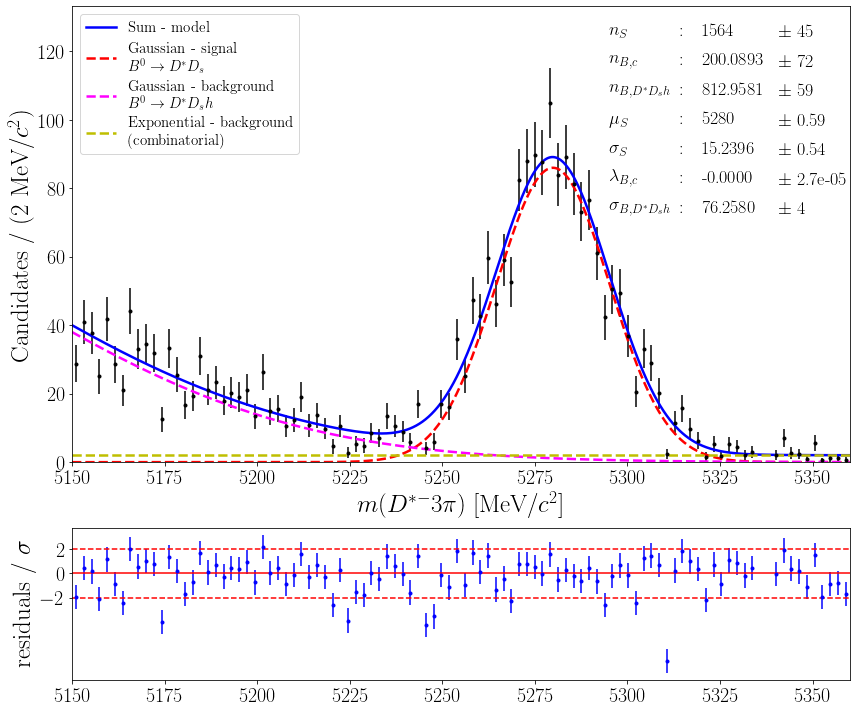

/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/all_data_strip_cutDeltaM_V8_fixedTail/B0_M_all_data_strip_cutDeltaM_Ds_weighted_V8_fit.pdf


In [18]:
plot_hist_fit_particle(df_Ds,'B0_M', models = [model_B0Ds, gaussianS_B0Ds_ext, gaussian_B0Ds_ext, exponential_B0Ds_ext],
                       name_models = ["", '\n $B^0\\to D^*D_s$','\n $B^0\\to D^*D_s h$',
                                      '\n (combinatorial)'],
                       obs=obs_B0Ds, n_bins = 100,mode_hist = False,
                       name_data = name_data_B0Ds, name_folder=name_data,
                       colors=['b','r','magenta','y'], weights=weights.sig,
                       params=params_B0Ds,name_params=name_params_B0Ds,
                       colWidths=[0.05,0.01,0.05,0.04],
                       fontsize_res = 18.,
                       fontsize_leg=15)

In [19]:
save_params(params_B0Ds, name_data_B0Ds, True)

parameters saved in /afs/cern.ch/user/c/correian/bd2dst3pi/output/json/all_data_strip_cutDeltaM_Ds_weighted_V8_params.json


## Fit on the full `B0_M`

In [20]:
low = 5150.
high = 5550.

### Data

In [23]:
# Result of the fit on the MC D0S->D*pipipi data with one of the pi misidentified as a kaon
with open(f'{loc.JSON}/data_KPiPi_2_params.json', 'r') as f:
    data_KPiPi_params = json.load(f)

for var in 'muL', 'muR', 'sigmaL', 'sigmaR': # conversion GeV -> MeV
    data_KPiPi_params[var] = data_KPiPi_params[var]*1000
    data_KPiPi_params[f"{var}_err"] = data_KPiPi_params[f"{var}_err"]*1000    
    
# Result of the previous fit on the B0_M sWeighted distribution with cut on tau_M around m(Ds)
with open(f'{loc.JSON}/{name_data_B0Ds}_params.json', 'r') as f:
    data_B0Ds_params = json.load(f)
    
# Result of the fit on the MC signal data
with open(f'{loc.JSON}/MC_params.json', 'r') as f:
    MC_param_results = json.load(f)

### Distribution

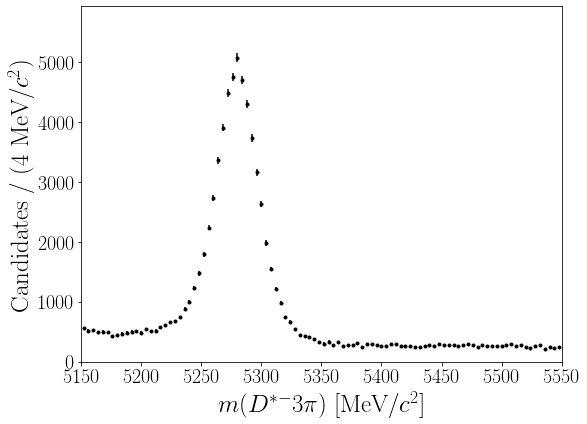

/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/B0_M_all_data_strip_cutDeltaM_V8_sim_B0_cut.pdf


In [8]:
fct.plot_hist_particle({name_data+'_B0_cut':df},'B0_M',
              low = low, high = high,
              n_bins = 100, mode_hist = False, colors='black')

### Initial values

In [24]:
n_events_B0_M = len(df.query(f'B0_M > {low} and B0_M < {high}'))

n_sig_k = 52000
n_bkg_k = 28000
n_bkg2_k = 500
n_bkgK_k = 3000


initial_values = {
    # Signal        
    'mu'       :{ 'value': 5279.                         , 'low': 5279.-5.       , 'high': 5279.+5.             , 'floating': True},
    'sigmaL'   :{ 'value': 17.9                          , 'low': 17.-15.        , 'high': 17.+15.              , 'floating': True},
    'sigmaR'   :{ 'value': 17.9                          , 'low': 17.-15.        , 'high': 17+15.               , 'floating': True},
    'alphaL'   :{ 'value': MC_param_results['alphaL_MC'] , 'low': 0.1            , 'high': 10.                  , 'floating': False},
    'alphaR'   :{ 'value': -MC_param_results['alphaR_MC'], 'low': -10.            , 'high': -0.1                , 'floating': False},
    'nL'       :{ 'value': MC_param_results['nL_MC']     , 'low': 0.1            , 'high': 200.                 , 'floating': False},
    'nR'       :{ 'value': MC_param_results['nR_MC']     , 'low': 1.             , 'high': 200.                 , 'floating': False},
    'frac'     :{ 'value': 0.5                           , 'low': 0.1              , 'high': 1.                  , 'floating': True},
    'n_sig'    :{ 'value': n_sig_k                       , 'low': n_sig_k*0.5    , 'high': n_events_B0_M        , 'floating': True},
    # Combinatorial background        
    'lambda'   :{ 'value': -0.0008                       , 'low': -0.01          , 'high': -0.00001             , 'floating': True},
    'n_bkg'    :{ 'value': n_bkg_k                       , 'low': n_bkg_k*0.5    , 'high': n_events_B0_M        , 'floating': True},
    # Partially reconstructed particles        
    'mu2'      :{ 'value': mu2_p                         , 'low': 4800.          , 'high': 5150.                , 'floating': False},
    'sigma2'   :{ 'value': 80.                           , 'low': 10.            , 'high': 5150.-mu2_p          , 'floating': True},
    'n_bkg2'   :{ 'value': n_bkg2_k                      , 'low': 0              , 'high': n_events_B0_M        , 'floating': True},
    # Background decay D*Kpipi    
    'n_bkgK'   :{ 'value': n_bkgK_k                      , 'low': 0              , 'high': n_events_B0_M        , 'floating': True},
}



for var in 'muL', 'muR', 'sigmaL', 'sigmaR', 'nL', 'nR', 'alphaL', 'alphaR', 'nL', 'nR', 'fraction':
    initial_values[f'{var}_K'] = {'value': data_KPiPi_params[var], 'low': None, 'high': None, 'floating': False}


### Observables and variables

In [25]:
obs = zfit.Space("x", limits=(low, high))

zparams = {}
for var in initial_values.keys():
    zparams[var] = zfit.Parameter(var,
                                  initial_values[var]['value'], 
                                  initial_values[var]['low'], 
                                  initial_values[var]['high'],
                                  floating = initial_values[var]['floating'])
    #print(zparams[var])

In [38]:
name_params = {
    # Signal
    'mu'      : '$\mu_S$',
    'sigmaL'  : '$\\sigma_{L_S}$',
    'sigmaR'  : '$\\sigma_{R_S}$',    
    'alphaL'  : '$\\alpha_{L_S}$',
    'alphaR'  : '$\\alpha_{R_S}$',
    'nL'      : '$n_L_S$',
    'nR'      : '$n_R_S$',
    'frac'    : '$f_{S, \\frac{L}{R}}$',
    'n_sig'   : '$n_S$',
    # Combinatorial background
    'n_bkg'   : '$n_{B,c}$',
    'lambda'  : '$\\lambda_{B,c}$',
    # Partially reconstructed brackground
    'mu2'     : '$\\mu_{B,D^*3\pi h}$',
    'sigma2'  : '$\\sigma_{B,D^*3\pi h}$',
    'n_bkg2'  : '$n_{B,D^*3\pi h}$',
    # Background decay D*Kpipi    
    'n_bkgK'  : '$n_{B,D^*K\pi\pi}$',
}


### PDFs

In [28]:
def crystall_ball_gaussian(mu, sigma, obs, alpha=None, n=None):
    if alpha is None or n is None:
        pdf = zfit.pdf.Gauss(mu, sigma, obs=obs)
    else:
        pdf = zfit.pdf.CrystalBall(mu, sigma, alpha, n, obs=obs)
    return pdf

def sum_crystalball(muL, muR, sigmaL, sigmaR, frac, obs, alphaL=None, alphaR=None, nL=None, nR=None):
    """ Return the sum of 2 crystall ball PDFs.
    If the alpha or n is None, the corresponding distribution is a gaussian.
    """
    pdfL = crystall_ball_gaussian(muL, sigmaL, obs,
                                         alphaL,nL)
    pdfR = crystall_ball_gaussian(muR, sigmaR, obs,
                                         alphaR, nR)
    
    model = zfit.pdf.SumPDF([pdfL, pdfR], fracs=frac)
    
    return model, pdfL, pdfR

In [31]:
model_S, crystalBallL_S, crystalBallR_S = sum_crystalball(zparams['mu'], zparams['mu'],
                                                          zparams['sigmaL'], zparams['sigmaR'],
                                                          zparams['frac'], obs,                                                          
                                                          zparams['alphaL'], zparams['alphaR'], 
                                                          zparams['nL'], zparams['nR']
                                                         )


gaussian_B0Ds = zfit.pdf.Gauss(zparams_B0Ds['mu_B0Ds'],zparams_B0Ds['sigma_B0Ds'],obs=obs)

model_K, crystalBallL_K, crystalBallR_K = sum_crystalball(zparams['muL_K'], zparams['muR_K'], 
                                                          zparams['sigmaL_K'], zparams['sigmaR_K'],
                                                          zparams['fraction_K'], obs,
                                                          zparams['alphaL_K'], zparams['alphaR_K'], 
                                                          zparams['nL_K'], zparams['nR_K'])

exponential = zfit.pdf.Exponential(zparams['lambda'], obs=obs)
gaussian = zfit.pdf.Gauss(zparams['mu2'],zparams['sigma2'],obs=obs)


model_S_ext = model_S.create_extended(zparams['n_sig'])
exp_ext = exponential.create_extended(zparams['n_bkg'])
gaussian_ext = gaussian.create_extended(zparams['n_bkg2'])
gaussian_B0Ds_ext = gaussian_B0Ds.create_extended(zparams_B0Ds['n_sig_B0Ds'])
model_K_ext = model_K.create_extended(zparams['n_bkgK'])

model = zfit.pdf.SumPDF([model_S_ext, gaussian_B0Ds_ext, gaussian_ext, model_K_ext, exp_ext]) # gauss is folded by frac
data = zfit.Data.from_pandas(df['B0_M'], obs=obs)

### Fit

In [43]:
import timeit
start = timeit.default_timer()
result, params = launch_fit(model, data, extended=True)
stop = timeit.default_timer()
print('Time to do the fit: ', stop - start) 

------------------------------------------------------------------
| FCN = -4.257e+05              |     Ncalls=228 (228 total)     |
| EDM = 0.000148 (Goal: 0.001)  |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
name             value    minuit_hesse         minuit_minos    at limit
----------  ----------  --------------  -------------------  ----------
n_sig            48080     +/- 4.1e+02  -4.1e+02   +

Result of the 1st fit

    ------------------------------------------------------------------
    | FCN = -4.257e+05              |    Ncalls=2002 (2002 total)    |
    | EDM = 0.000785 (Goal: 0.001)  |            up = 0.5            |
    ------------------------------------------------------------------
    |  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
    ------------------------------------------------------------------
    |     True      |     True      |   False   |       False        |
    ------------------------------------------------------------------
    | Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
    ------------------------------------------------------------------
    |     False     |     True      |   True    |   True    | False  |
    ------------------------------------------------------------------
    name            value    minuit_hesse         minuit_minos    at limit
    ----------  ---------  --------------  -------------------  ----------
    n_sig           48080     +/- 6.5e+02  -  4e+02   +1.5e+03       False
    n_sig_B0Ds       5549     +/-      31  -1.6e+03   +3.9e+03       False
    n_bkg2          384.5     +/- 1.6e+02  -     97   +1.2e+02       False
    n_bkgK           1536     +/- 4.3e+02  -4.1e+02   +4.3e+02       False
    n_bkg           30260     +/- 5.5e+02  -  5e+02   +  5e+02       False
    frac           0.4287     +/-   0.056  -  0.048   +  0.051       False
    mu               5279     +/-    0.14  -   0.12   +   0.14       False
    sigmaL          13.11     +/-    0.55  -   0.52   +   0.51       False
    sigmaR          22.01     +/-    0.58  -   0.45   +   0.58       False
    mu_B0Ds          5283     +/-  0.0095  -    1.5   +    1.5        True
    sigma_B0Ds         20     +/-  0.0063  -    2.1   +    2.1        True
    sigma2          33.93     +/-     8.3  -    5.1   +    6.3       False
    lambda      -0.000987     +/- 0.00015  -0.00013   +0.00014       False
    Time to do the fit:  399.28426738642156

Result of the 2nd fit

    ------------------------------------------------------------------
    | FCN = -4.257e+05              |     Ncalls=228 (228 total)     |
    | EDM = 0.000148 (Goal: 0.001)  |            up = 0.5            |
    ------------------------------------------------------------------
    |  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
    ------------------------------------------------------------------
    |     True      |     True      |   False   |       False        |
    ------------------------------------------------------------------
    | Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
    ------------------------------------------------------------------
    |     False     |     True      |   True    |   True    | False  |
    ------------------------------------------------------------------
    name             value    minuit_hesse         minuit_minos    at limit
    ----------  ----------  --------------  -------------------  ----------
    n_sig            48080     +/- 4.1e+02  -4.1e+02   +1.5e+03       False
    n_sig_B0Ds        5549     +/-     8.2  -1.6e+03   +3.5e+03        True
    n_bkg2           384.9     +/- 1.1e+02  -1.1e+02   +1.2e+02       False
    n_bkgK            1536     +/- 4.1e+02  -4.1e+02   +3.9e+02       False
    n_bkg            30260     +/- 4.9e+02  -  5e+02   +  5e+02       False
    frac            0.4287     +/-   0.052  -  0.048   +  0.051       False
    mu                5279     +/-    0.14  -   0.12   +   0.14       False
    sigmaL           13.11     +/-    0.53  -   0.52   +   0.51       False
    sigmaR           22.01     +/-    0.51  -   0.51   +   0.51       False
    mu_B0Ds           5283     +/-   0.003  -    1.5   +    1.5        True
    sigma_B0Ds          20     +/-  0.0021  -    6.2   +    6.2        True
    sigma2           33.88     +/-     5.5  -      5   +    6.3       False
    lambda      -0.0009869     +/- 0.00013  -0.00013   +0.00014       False
    Time to do the fit:  250.74356847116724


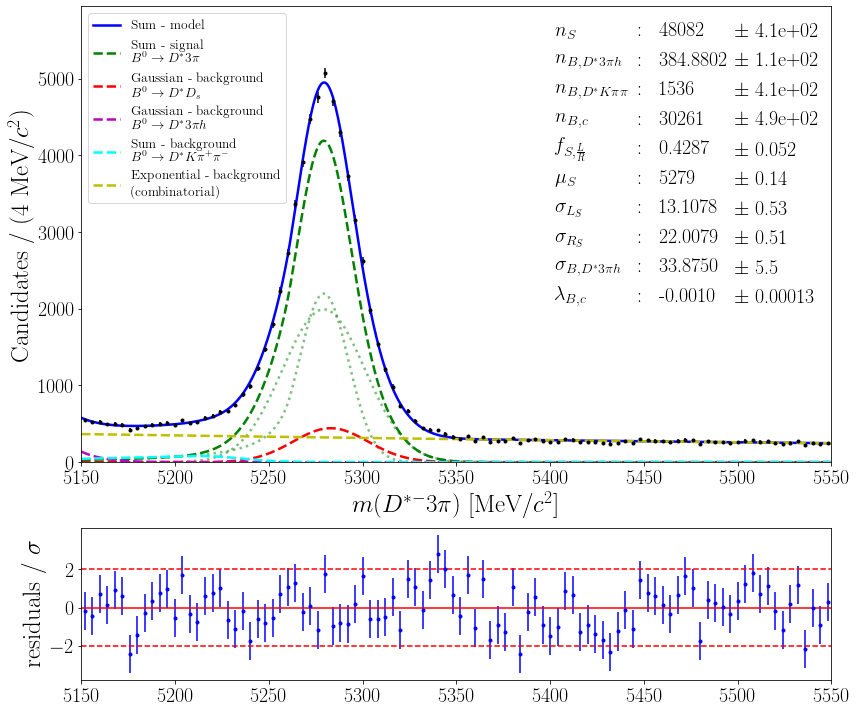

/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/all_data_strip_cutDeltaM_V8_fixedTail/B0_M_all_data_strip_cutDeltaM_V8_fixedTail_fit.pdf


In [44]:
plot_hist_fit_particle(df,'B0_M', models = [model,[model_S_ext, crystalBallL_S, crystalBallR_S], gaussian_B0Ds_ext, gaussian_ext, model_K_ext,exp_ext],
                       name_models = ["", '\n $B^0\\to D^* 3\pi$','\n $B^0\\to D^*D_s$','\n $B^0\\to D^*3\pi h$',
                                      '\n $B^0\\to D^* K \pi^+\pi^-$','\n (combinatorial)'],
                       obs=obs, n_bins = 100,mode_hist = False,
                       name_data = name_data, name_folder=name_data,
                       colors=['b','g','r','m','cyan','y'],
                       params=params,name_params=name_params, 
                       fontsize_leg=13.5,
                       colWidths=[0.06,0.01,0.05,0.06]
                      )

In [45]:
save_params(params,name_data,True)

parameters saved in /afs/cern.ch/user/c/correian/bd2dst3pi/output/json/all_data_strip_cutDeltaM_V8_fixedTail_params.json
